# Prepare

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
np.set_printoptions(precision=4, suppress=True)
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use(['seaborn-v0_8', 'seaborn-v0_8-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
dfTelco = pd.read_csv("https://raw.githubusercontent.com/hungpq7/data-chilly/main/data/telco_churn_customer.csv")
dfTelco.head()

,Customerid,Gender,Age,SeniorCitizen,Married,NumberOfDependents,Country,State,City,Latitude,Longitude,NumberOfReferrals,TenureInMonths,AvgMonthlyLongDistanceCharges,MultipleLines,InternetService,InternetType,AvgMonthlyGbDownload,Contract,PaymentMethod,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,SatisfactionScore,ChurnLabel,ChurnScore,Cltv,ChurnCategory
0,8779-QRDMV,Male,78,Yes,No,0,United States,California,Los Angeles,34.023810,-118.156582,0,1,0.00,No,Yes,DSL,8,Month-to-Month,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,3,Yes,91,5433,Competitor
1,7495-OOKFY,Female,74,Yes,Yes,1,United States,California,Los Angeles,34.044271,-118.185237,1,8,48.85,Yes,Yes,Fiber Optic,17,Month-to-Month,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,3,Yes,69,5302,Competitor
2,1658-BYGOY,Male,71,Yes,No,3,United States,California,Los Angeles,34.108833,-118.229715,0,18,11.33,Yes,Yes,Fiber Optic,52,Month-to-Month,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,2,Yes,81,3179,Competitor
3,4598-XLKNJ,Female,78,Yes,Yes,1,United States,California,Inglewood,33.936291,-118.332639,1,25,19.76,No,Yes,Fiber Optic,12,Month-to-Month,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,2,Yes,88,5337,Dissatisfaction
4,4846-WHAFZ,Female,80,Yes,Yes,1,United States,California,Whittier,33.972119,-118.020188,1,37,6.33,Yes,Yes,Fiber Optic,14,Month-to-Month,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,2,Yes,67,2793,Price


In [ ]:
dfTelco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customerid                     7043 non-null   object 
 1   Gender                         7043 non-null   object 
 2   Age                            7043 non-null   int64  
 3   SeniorCitizen                  7043 non-null   object 
 4   Married                        7043 non-null   object 
 5   NumberOfDependents             7043 non-null   int64  
 6   Country                        7043 non-null   object 
 7   State                          7043 non-null   object 
 8   City                           7043 non-null   object 
 9   Latitude                       7043 non-null   float64
 10  Longitude                      7043 non-null   float64
 11  NumberOfReferrals              7043 non-null   int64  
 12  TenureInMonths                 7043 non-null   i

Demographic:
- Gender
- Age
- Married
- NumberOfDependents

Geographic:
- Country
- State
- City
- Latitude
- Longitude

Services:
- TenureInMonths
- NumberOfReferrals
- MultipleLines
- InternetType
- Contract
- PaymentMethod
- SatisfactionScore

Charges:
- AvgMonthlyGbDownload
- AvgMonthlyLongDistanceCharges
- MonthlyCharge
- TotalCharges
- TotalRefunds
- TotalExtraDataCharges
- TotalLongDistanceCharges
- TotalRevenue
- CLTV

Churn:
- ChurnScore
- ChurnLabel
- ChurnCategory

# 1.&nbsp;Is the data valid?
- All customer are in California, USA: Yes.
- Check whether the column `SeniorCitizen` is compatible with column `Age`: Yes.
- Check whether `AvgMonthlyLongDistanceCharges = TotalLongDistanceCharges / TenureInMonths`: Yes.
- Check whether `MonthlyCharge = TotalCharges / TenureInMonths`: No.
- Check whether `TotalRevenue = TotalCharges - TotalRefunds`: Yes.


In [ ]:
dfTelco[['Country', 'State']].value_counts().rename('Count').reset_index()

,Country,State,Count
0,United States,California,7043


In [ ]:
dfTelco.groupby('SeniorCitizen')['Age'].agg([min, max]).reset_index()

,SeniorCitizen,min,max
0,No,19,64
1,Yes,65,80


In [ ]:
diff = dfTelco['TotalLongDistanceCharges'] / dfTelco['TenureInMonths'] - dfTelco['AvgMonthlyLongDistanceCharges']
diff.abs().max().round(6)

0.0

In [ ]:
diff = dfTelco['TotalCharges'] / dfTelco['TenureInMonths'] - dfTelco['MonthlyCharge']
diff.abs().max().round(6)

19.125

In [ ]:
diff = (
    dfTelco['TotalRevenue']
    + dfTelco['TotalRefunds']
    - dfTelco['TotalCharges']
    - dfTelco['TotalExtraDataCharges']
    - dfTelco['TotalLongDistanceCharges']
)
diff.abs().max().round(6)

0.0

In [ ]:
def map_binary(x):
    if x.lower() == 'yes': return 1
    elif x.lower() == 'no': return 0
    else: return np.nan

dfTelco = (
    dfTelco
    .eval('AvgMonthlyRevenue = TotalRevenue / TenureInMonths')
    .eval('AvgMonthlyCharges = TotalCharges / TenureInMonths')
    .eval('AvgMonthlyRefunds = TotalRefunds / TenureInMonths')
    .eval('AvgMonthlyExtraDataCharges = TotalExtraDataCharges / TenureInMonths')
    .assign(SeniorCitizen = dfTelco['SeniorCitizen'].map(map_binary))
    .assign(Married = dfTelco['Married'].map(map_binary))
    .assign(MultipleLines = dfTelco['MultipleLines'].map(map_binary))
    .assign(ChurnLabel = dfTelco['ChurnLabel'].map(map_binary))
    .drop(columns=['Country', 'State', 'InternetService'])
)

# 2.&nbsp;Who are our customers?

## 2.1. Demographic
- Same ratio between Male & Female, also being consistent across different ages.
- Same ratio between Married & Not married (surprisingly).
- `Ages < 65` distributes uniformally. `Age > 65` also distributes uniformally, but lower density.

In [ ]:
dfTelco[['Gender', 'Married']].value_counts(normalize=True).rename('Ratio').reset_index()

,Gender,Married,Ratio
0,Male,0,0.261394
1,Female,0,0.255573
2,Male,1,0.243362
3,Female,1,0.239671


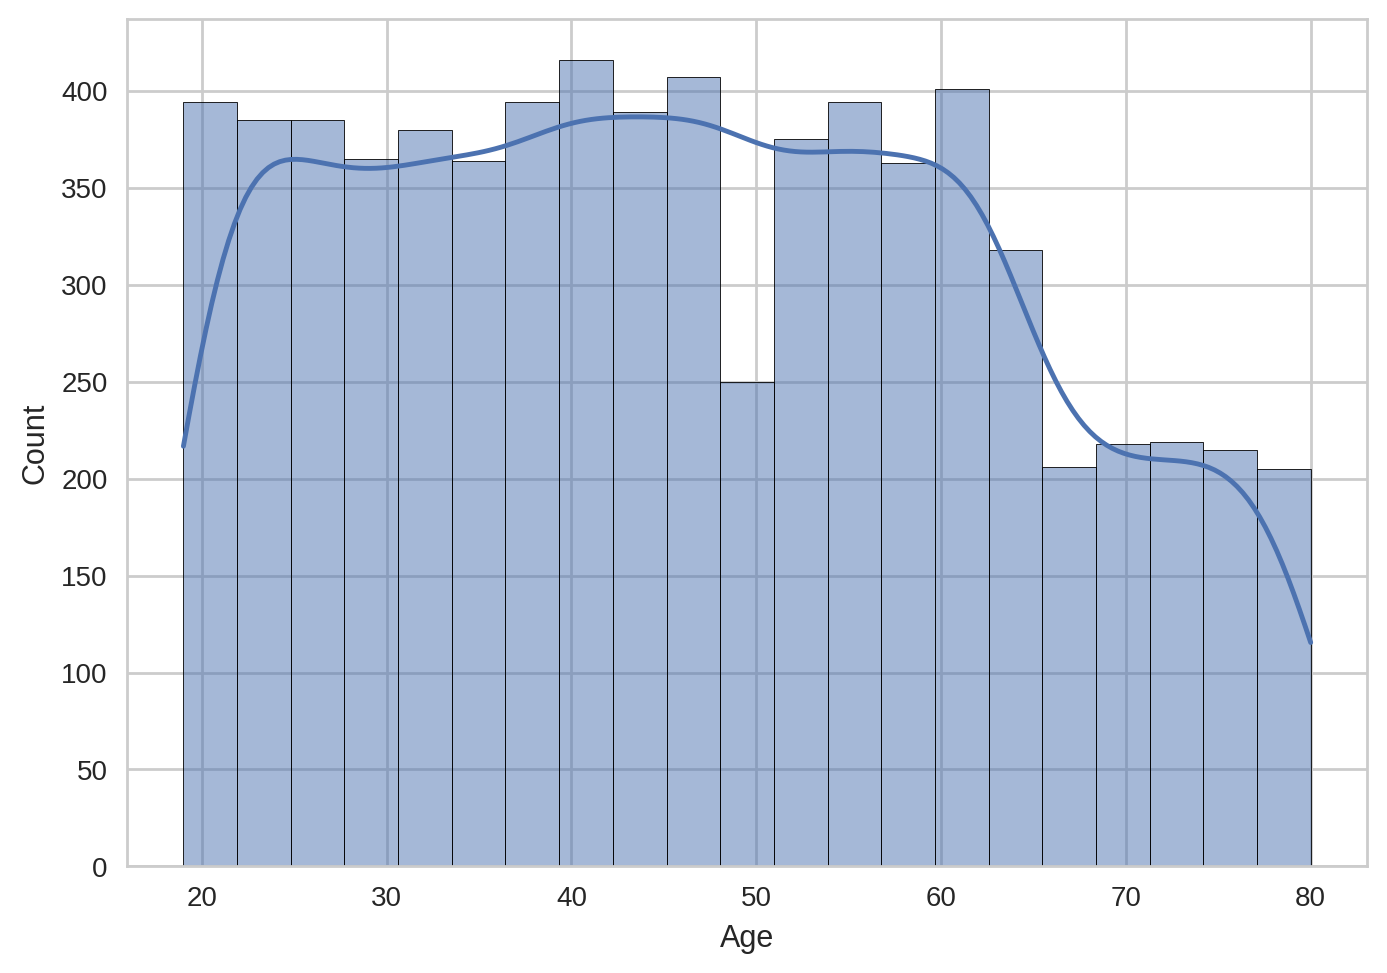

In [ ]:
sns.histplot(dfTelco, x='Age', kde=True)
plt.show()

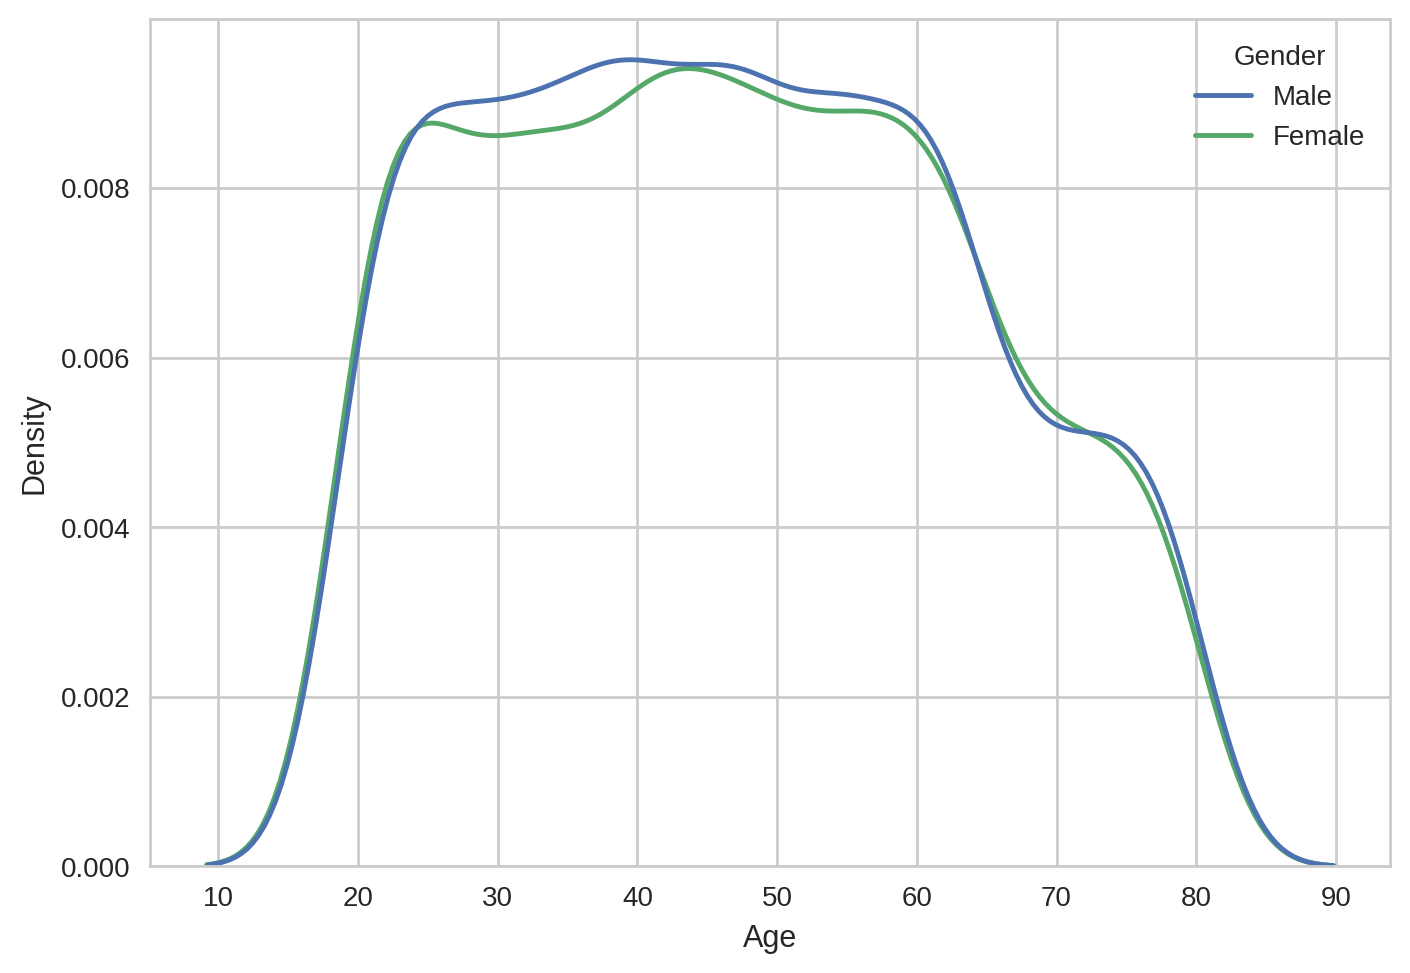

In [ ]:
sns.kdeplot(dfTelco, x='Age', hue='Gender')
plt.show()

In [ ]:
df = dfTelco['NumberOfDependents'].map(lambda x: x if x < 4 else 'Above 4').value_counts().reset_index()
df.columns = ['NumberOfDependents', 'Count']
df

,NumberOfDependents,Count
0,0,5416
1,1,553
2,2,531
3,3,517
4,Above 4,26


## 2.2. Geographic
- Very high density in **seaside** cities: Los Angeles, San Diego, San Jose, Sacramento and San Francisco.

In [ ]:
fig = px.density_mapbox(
    dfTelco,
    lat='Latitude', lon='Longitude',
    radius=5,
    zoom=4,
    color_continuous_scale='Tealgrn',
    mapbox_style="carto-positron"
)

fig.show()

In [ ]:
dfTelco['City'].value_counts().head(10)

Los Angeles      293
San Diego        285
San Jose         112
Sacramento       108
San Francisco    104
Fresno            61
Long Beach        60
Oakland           52
Escondido         51
Stockton          44
Name: City, dtype: int64

# 3.&nbsp;Customers at our company
- Majority of customers (1) comes from the **early days** of the company and (2) are **newly acquired**.
- Telephone: customers using multiple phones have longer tenure than customers using a single phone.
- The most important customer segment: using both **multiple lines** (telephone) and **fiber optic** (internet): 27% number of customers, contributing 45% total revenue.
- MutiLines customers prefer yearly payment, while FiberOptic customers prefer monthly payment, comparing to the average.

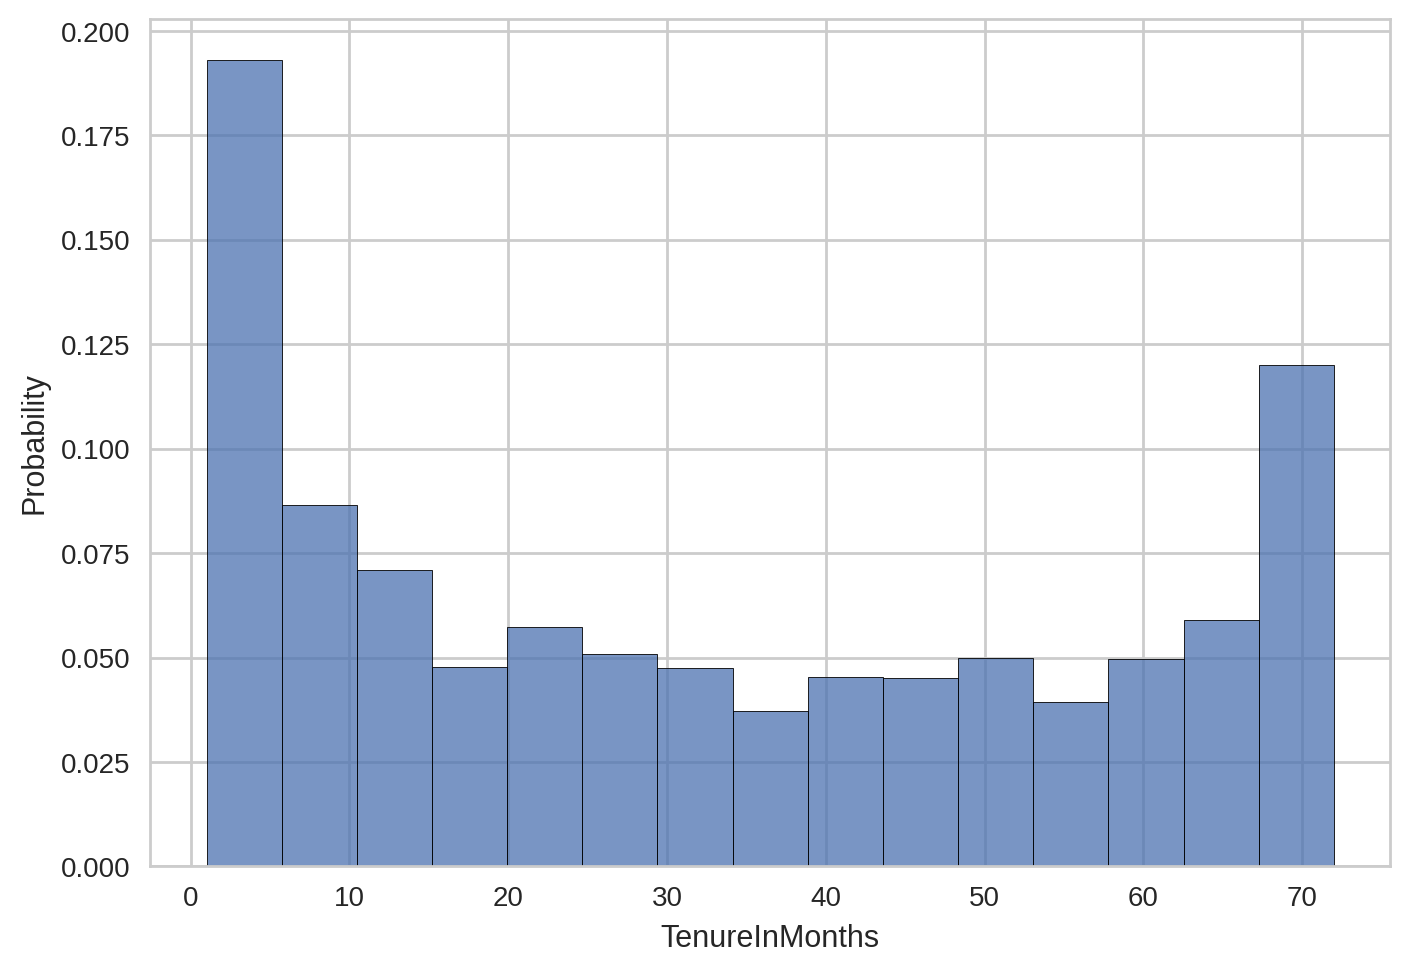

In [ ]:
sns.histplot(dfTelco, x='TenureInMonths', stat='probability')
plt.show()

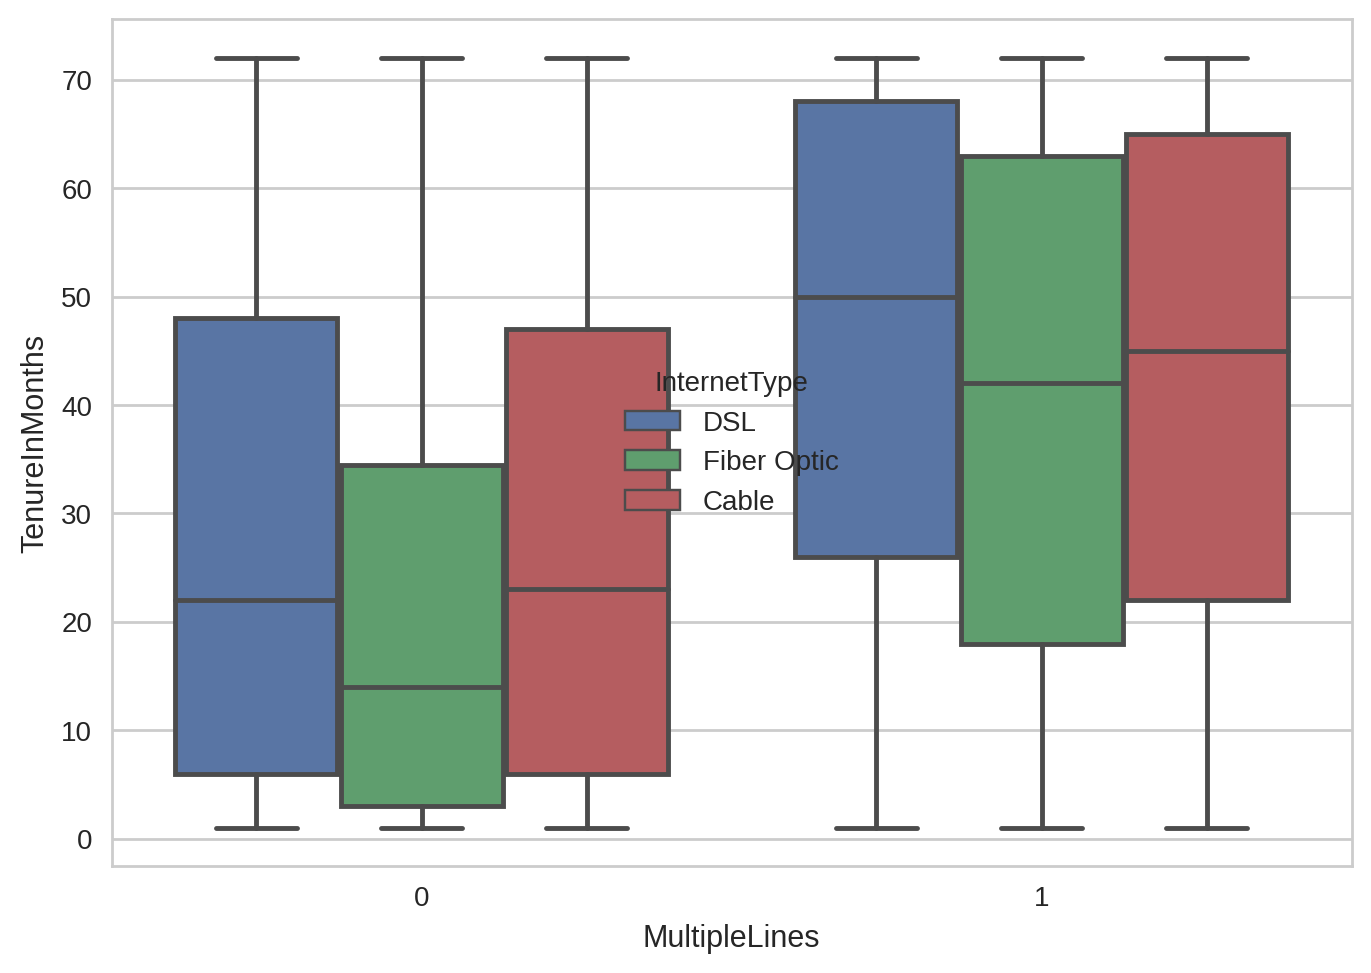

In [ ]:
sns.boxplot(dfTelco.query("InternetType != 'None'"), x='MultipleLines', y='TenureInMonths', hue='InternetType')
plt.show()

In [ ]:
df = dfTelco.pivot_table(index='MultipleLines', columns='InternetType', values='Customerid', aggfunc=np.size)
df = df / dfTelco.shape[0]
df.style.format('{:.0%}')

InternetType,Cable,DSL,Fiber Optic,None
MultipleLines,,,,
0,8%,17%,16%,17%
1,3%,7%,27%,5%


In [ ]:
df = dfTelco.pivot_table(index='MultipleLines', columns='InternetType', values='TotalRevenue', aggfunc=np.sum)
df = df / dfTelco['TotalRevenue'].sum()
df.style.format('{:.0%}')

InternetType,Cable,DSL,Fiber Optic,None
MultipleLines,,,,
0,6%,11%,13%,6%
1,5%,11%,45%,4%


In [ ]:
df = dfTelco.pivot_table(index='Contract', columns='MultipleLines', values='Customerid', aggfunc=np.size)
df /= dfTelco.shape[0]
df.style.format('{:.0%}')

MultipleLines,0,1
Contract,,
Month-to-Month,32%,19%
One Year,13%,9%
Two Year,13%,14%


In [ ]:
df = dfTelco.pivot_table(index='Contract', columns='InternetType', values='Customerid', aggfunc=np.size)
df /= dfTelco.shape[0]
df.style.format('{:.0%}')

InternetType,Cable,DSL,Fiber Optic,None
Contract,,,,
Month-to-Month,6%,11%,27%,7%
One Year,3%,6%,8%,5%
Two Year,3%,7%,8%,9%


In [ ]:
dfTelco.pivot_table(index='Contract', columns='PaymentMethod', values='Customerid', aggfunc=np.size)

PaymentMethod,Bank Withdrawal,Credit Card,Mailed Check
Contract,,,
Month-to-Month,2240,1136,234
One Year,797,671,82
Two Year,872,942,69


# 4.&nbsp;Customer spendings
- Younger customers tend to use download more.
- Variables about charges are highly correlated with each other, as well as tenure, revenue and CLV.
- Three-fourth revenue comes from subsription, one-fourth comes from long-distance charges.
- Customers' monthly charge distribution: two peaks at around 50 and 110 USD/month. If being asked thresholds which define VIP levels, I would suggest **130 and 75 USD/month**. Why? Because this is equivalent to 1 VIP1, 4 VIP2 and 3 VIP3 for every 8 customers.
- Pareto chart of revenue increases very quickly, then slows down when approaching 100%. It shows that **20% top customers contribute to 50% total revenue** and 40% top customers contribute to 80% total revenue.

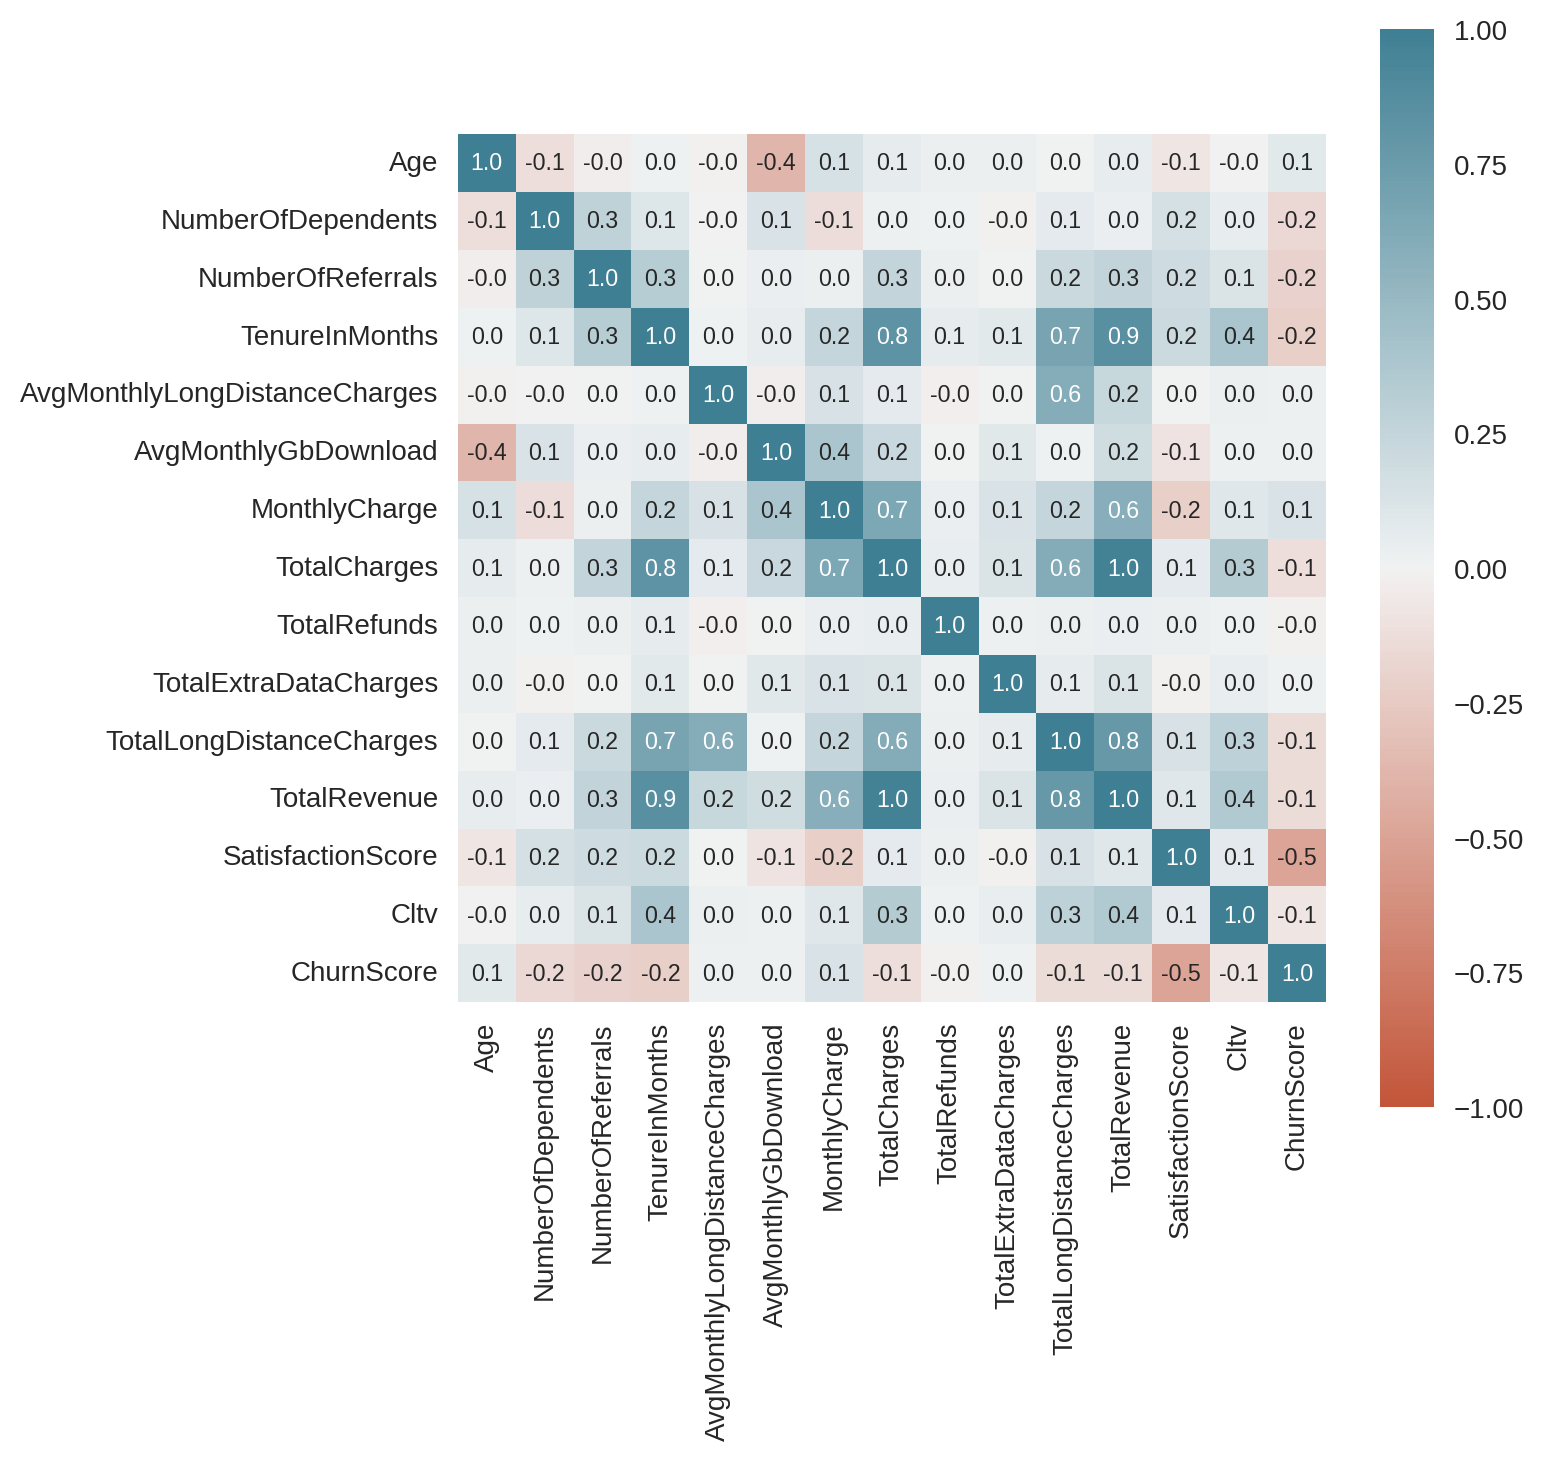

In [ ]:
subset = [
    'Age','NumberOfDependents','NumberOfReferrals','TenureInMonths','AvgMonthlyLongDistanceCharges',
    'AvgMonthlyGbDownload','MonthlyCharge','TotalCharges','TotalRefunds','TotalExtraDataCharges',
    'TotalLongDistanceCharges','TotalRevenue','SatisfactionScore','Cltv','ChurnScore'
]

palette = sns.diverging_palette(20, 220, as_cmap=True)

plt.figure(figsize=(7,7))
sns.heatmap(
    dfTelco[subset].corr(),
    square=True, annot=True,
    cmap=palette, fmt='.1f',
    vmin=-1, vmax=1, annot_kws={'fontsize': 'smaller '}
)
plt.show()

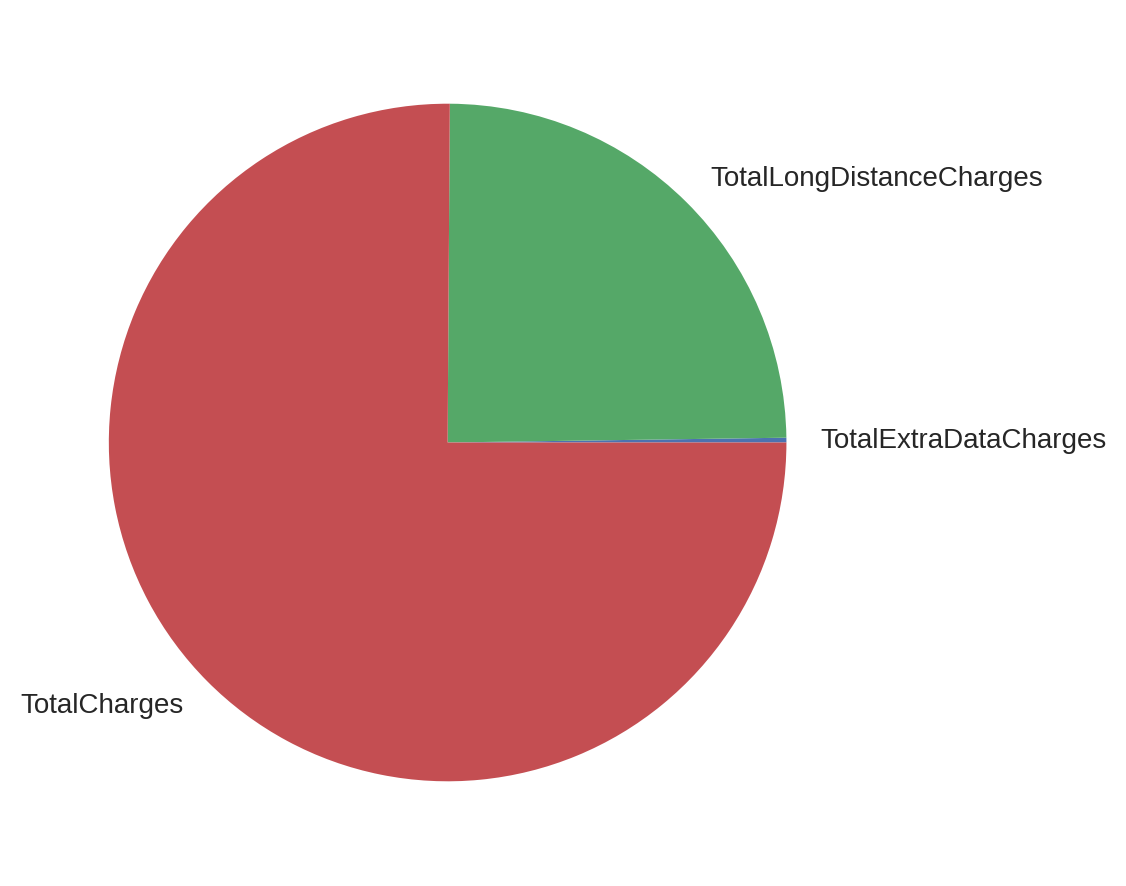

In [ ]:
subset = ['TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalCharges']
dfTelco[subset].sum().plot(kind='pie')
plt.show()

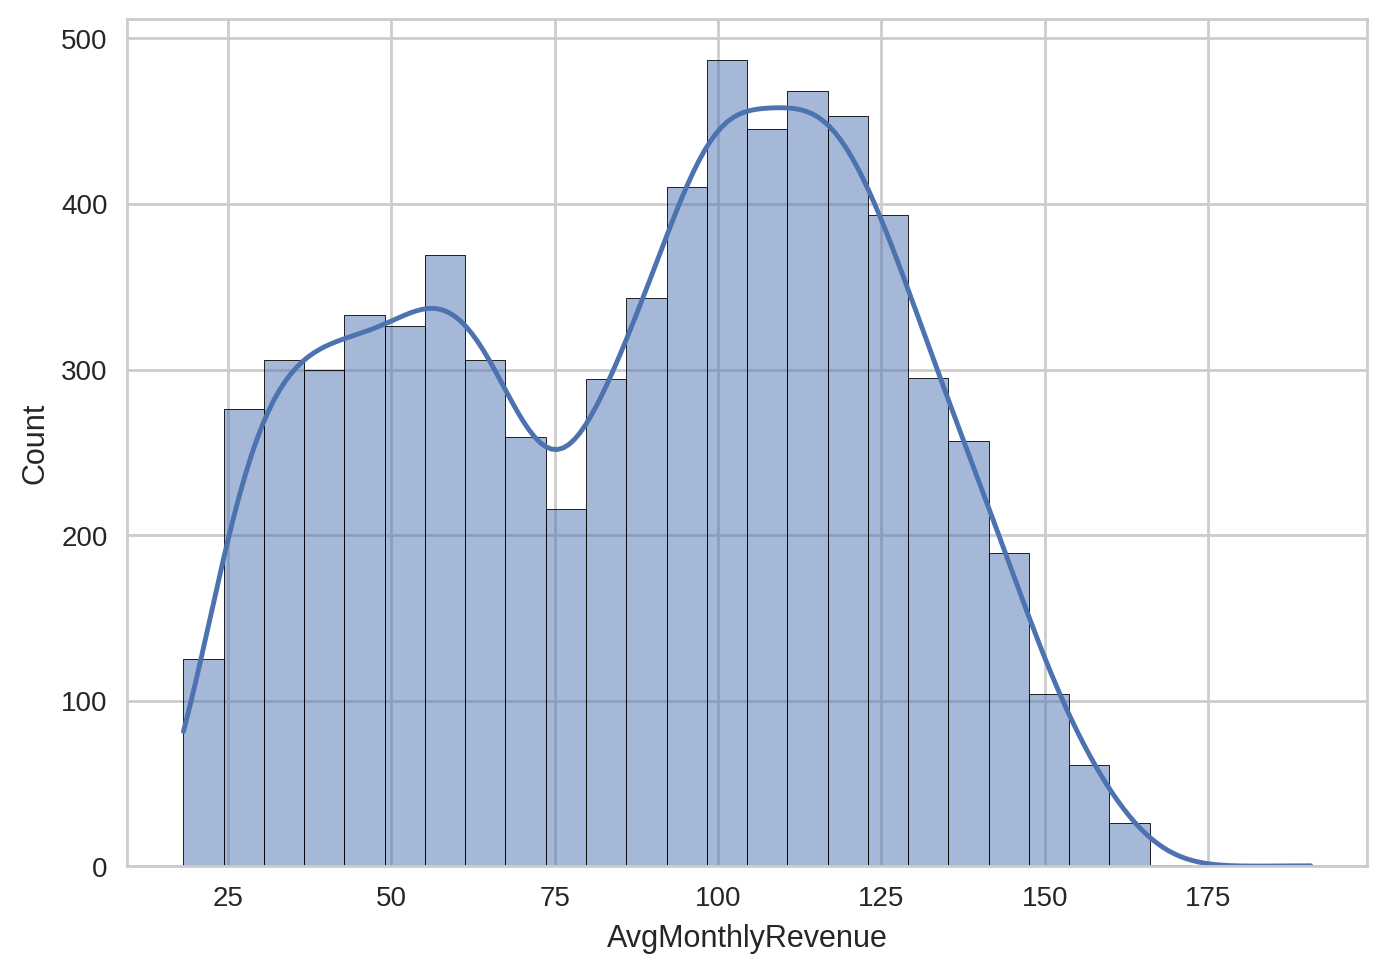

In [ ]:
sns.histplot(dfTelco, x='AvgMonthlyRevenue', kde=True)
plt.show()

In [ ]:
dfTelco['AvgMonthlyRevenue'].quantile([0.375, 0.875])

0.375     75.063291
0.875    130.336745
Name: AvgMonthlyRevenue, dtype: float64

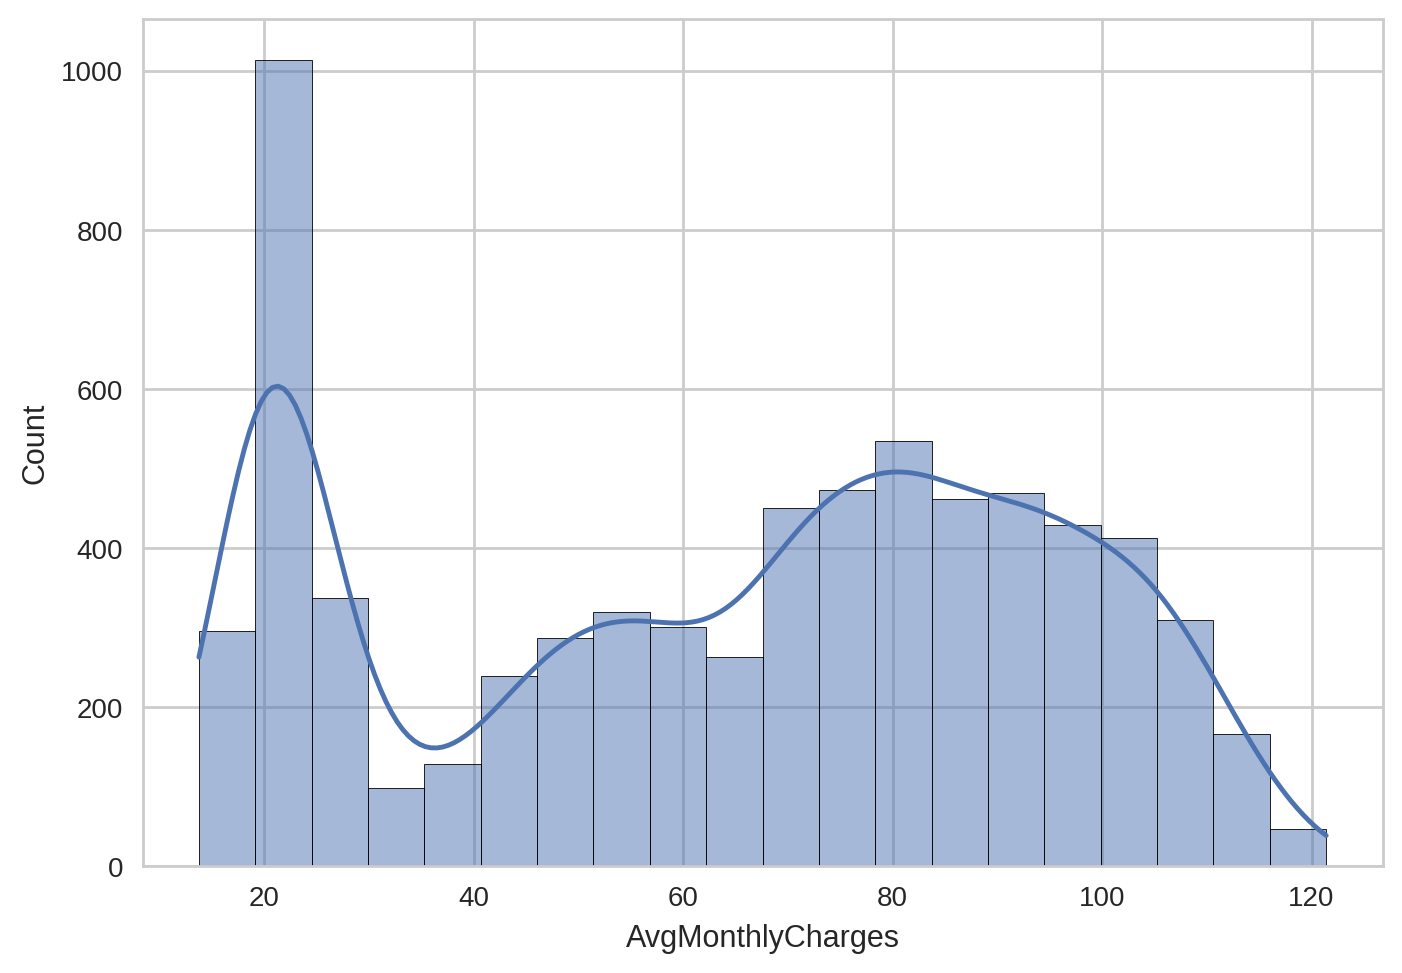

In [ ]:
sns.histplot(dfTelco, x='AvgMonthlyCharges', kde=True)
plt.show()

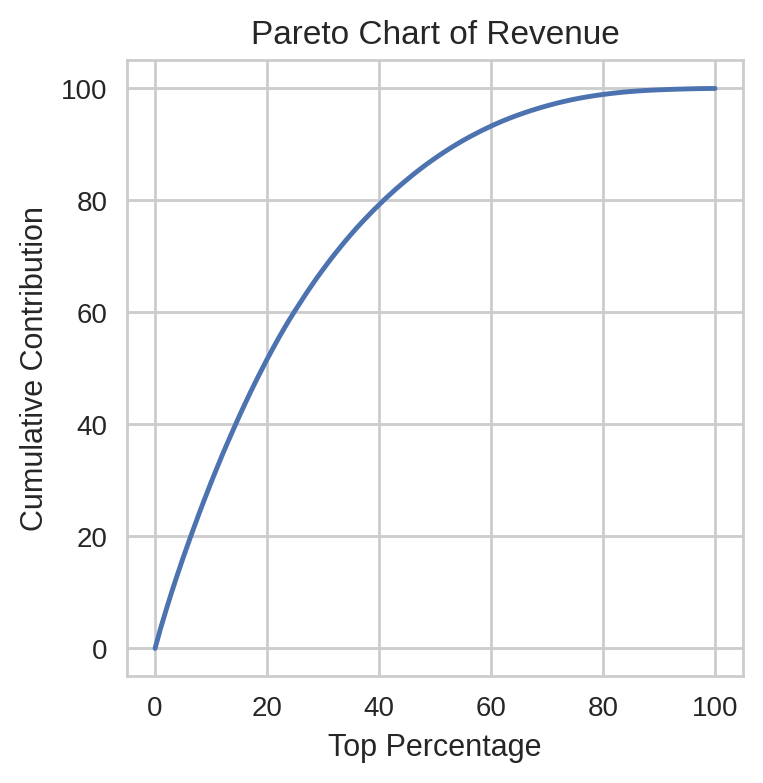

In [ ]:
def ParetoChart(series, varname, ax=None):
    series = np.array(series).flatten()
    top_percentage = 100 - pd.qcut(series, 100, np.arange(100)).astype(int)
    df = pd.DataFrame({varname: series, 'top_percentage': top_percentage})
    df = df.groupby('top_percentage')[varname].sum().to_frame().reset_index()
    df = df.assign(cumsum = df[varname].cumsum())
    df = df.assign(pct_contribution = df['cumsum'] / df[varname].sum() * 100)
    df = df[['top_percentage', 'pct_contribution']]
    df.loc[df.shape[0]] = [0, 0]
    df = df.sort_values('top_percentage')

    ax = plt.gca() if ax is None else ax
    ax.plot(df['top_percentage'], df['pct_contribution'])
    ax.axis('scaled')
    ax.set_xlabel('Top Percentage')
    ax.set_ylabel('Cumulative Contribution')
    ax.set_title(f'Pareto Chart of {varname.title()}')
    return ax

fig, ax = plt.subplots(figsize=(4,4))
ParetoChart(dfTelco['TotalRevenue'], 'revenue', ax=ax)
plt.show()

# 5.&nbsp;Churn analysis

## 5.1. Churn state
- Churned customers are more likely to be on a month-to-month contract. Maybe it is **easier to break a monthly contract**?
- Customers with low charges (~20 USD/month) are less likely to churn, while customers with high charges (100-120 USD/month) are more likely to churn. Maybe **our services are too expensive**?
- Older customers are a bit more likely to churn. The difference in average age is only about 3 years.
- Some cities have a significantly high churn rate: San Diego, Fallbrook, Temecula (> 50%).
- Customers who have refered only 0 or 1 person, and customers using Fiber Optic is more likely to churn. On the other hand, customers using a credit card and customers not using internet have a low churn rate.

In [ ]:
df = dfTelco['ChurnLabel'].value_counts(normalize=True).reset_index()
df.columns = ['ChurnLabel', 'Percent']
df.style.format({'Percent': '{:.2%}'})

,ChurnLabel,Percent
0,0,73.46%
1,1,26.54%


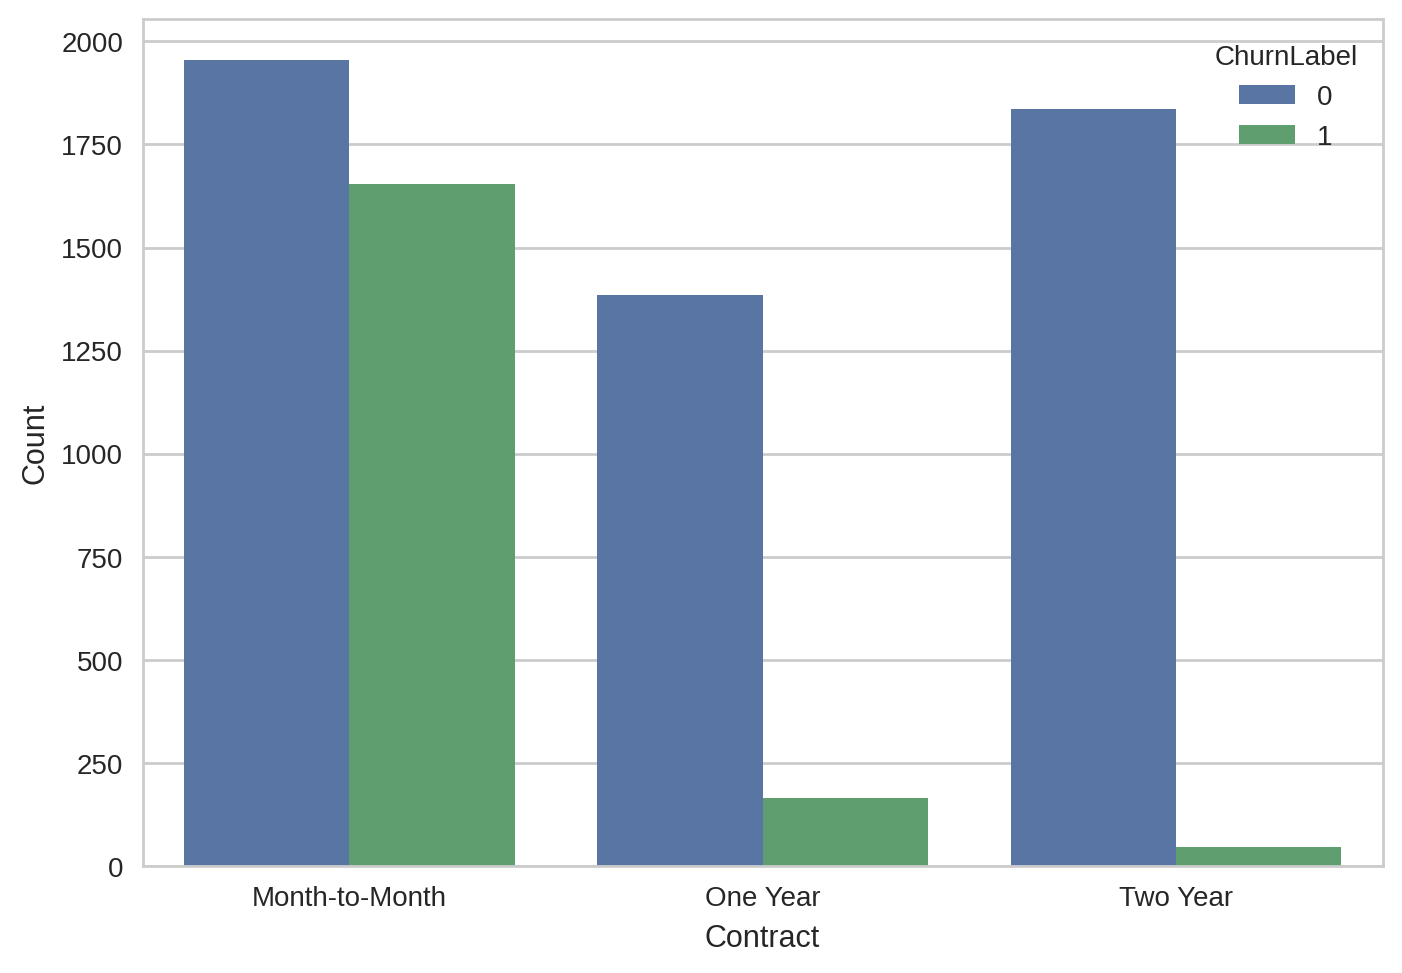

In [ ]:
df = dfTelco.groupby(['Contract', 'ChurnLabel']).size().rename('Count').reset_index()
sns.barplot(df, x='Contract', y='Count', hue='ChurnLabel')
plt.show()

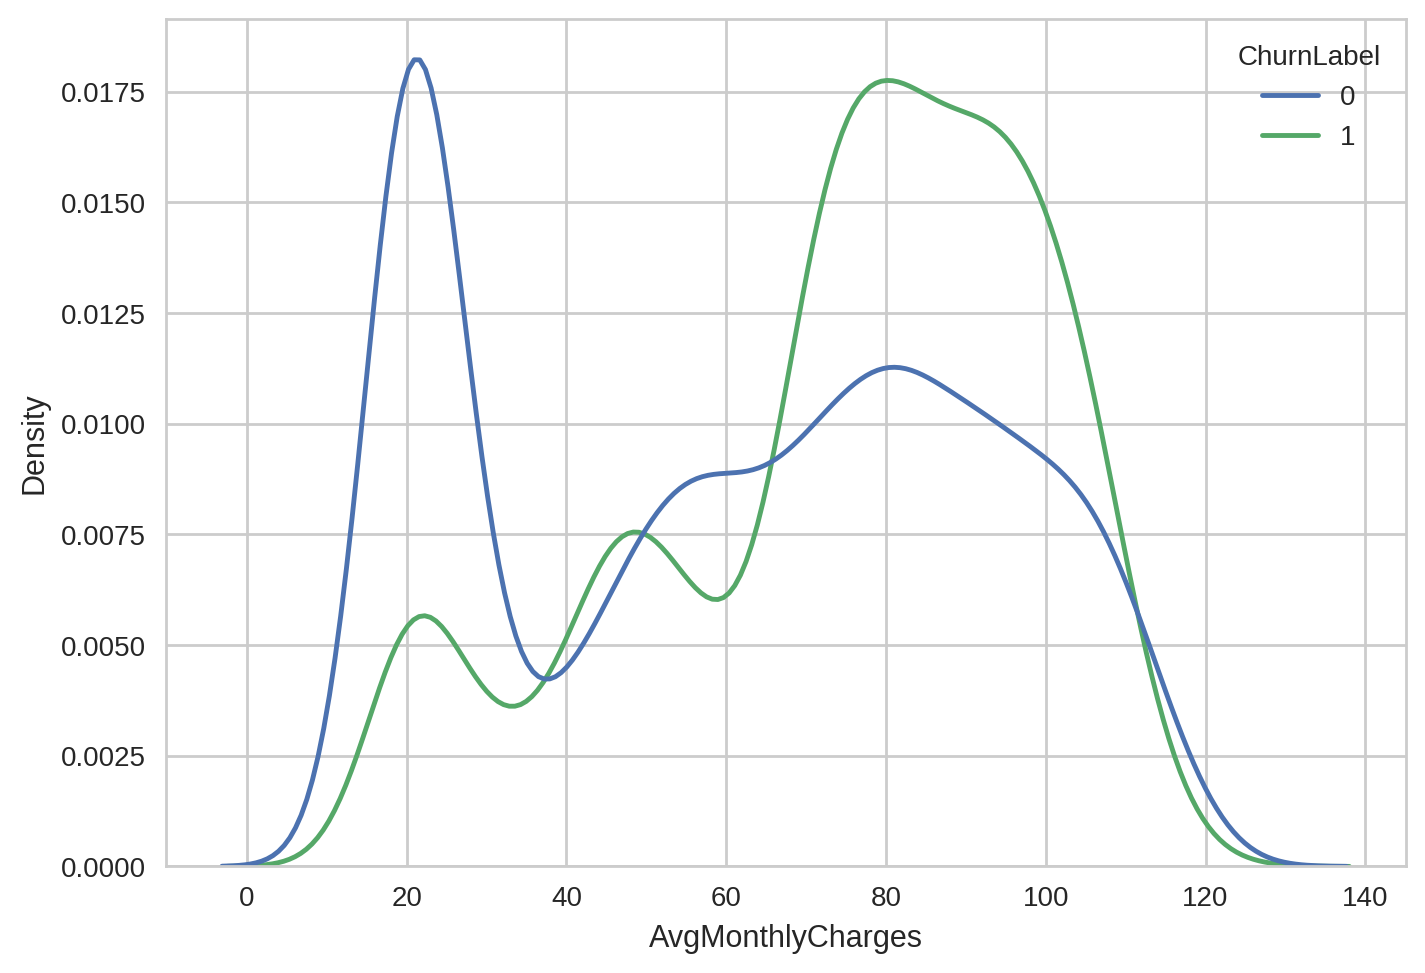

In [ ]:
dfTelco['AvgMonthlyCharges'] = dfTelco['TotalCharges'] / dfTelco['TenureInMonths']
sns.kdeplot(dfTelco, x='AvgMonthlyCharges', hue='ChurnLabel', common_norm=False)
plt.show()

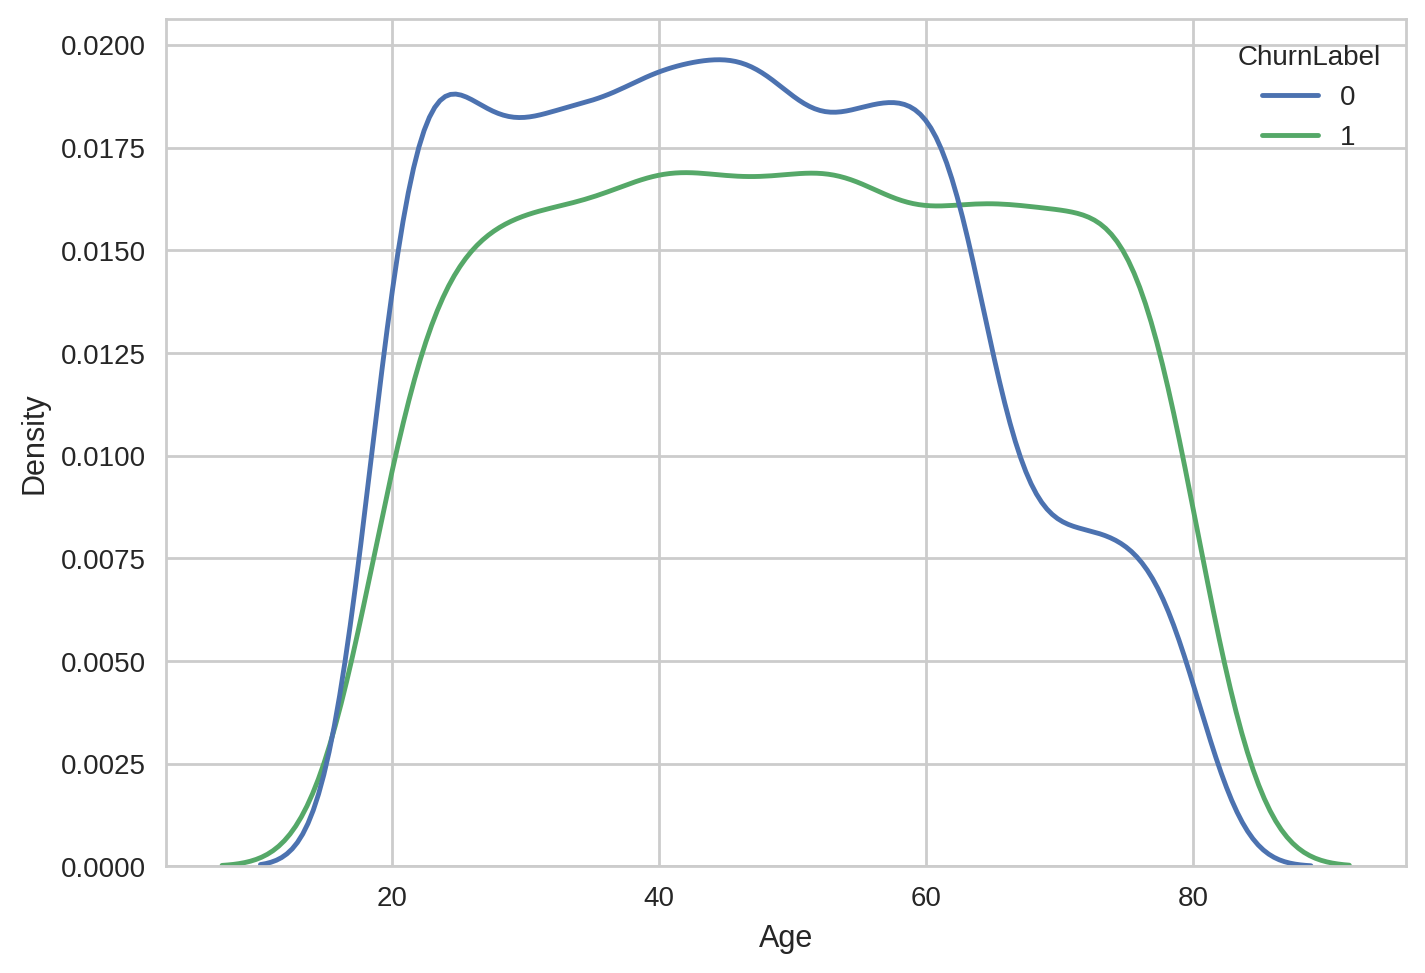

In [ ]:
sns.kdeplot(dfTelco, x='Age', hue='ChurnLabel', common_norm=False)
plt.show()

In [ ]:
x1 = dfTelco[dfTelco['ChurnLabel']==1]['Age']
x2 = dfTelco[dfTelco['ChurnLabel']==0]['Age']

stats.ttest_ind(x1, x2+3, equal_var=False, alternative='greater')
# accept alternative

Ttest_indResult(statistic=2.9864457990377797, pvalue=0.0014222772994544278)

In [ ]:
df1 = dfTelco[['City']].value_counts().rename('TotalCount').reset_index()
df2 = dfTelco.query("ChurnLabel==1")[['City']].value_counts().rename('ChurnCount').reset_index()
df = df1.merge(df2, how='left', on='City').fillna(0)
df['ChurnRatio'] = (df['ChurnCount'] + 1) / (df['TotalCount'] + 2)
df.sort_values('ChurnRatio', ascending=False).query('TotalCount >= 20').head(10)

,City,TotalCount,ChurnCount,ChurnRatio
1,San Diego,285,185.0,0.648084
10,Fallbrook,43,26.0,0.600000
13,Temecula,38,22.0,0.575000
28,Santa Rosa,24,11.0,0.461538
32,North Hollywood,20,9.0,0.454545
20,Modesto,28,12.0,0.433333
22,Santa Barbara,28,10.0,0.366667
26,Torrance,25,8.0,0.333333
11,Glendale,40,13.0,0.333333
8,Escondido,51,16.0,0.320755


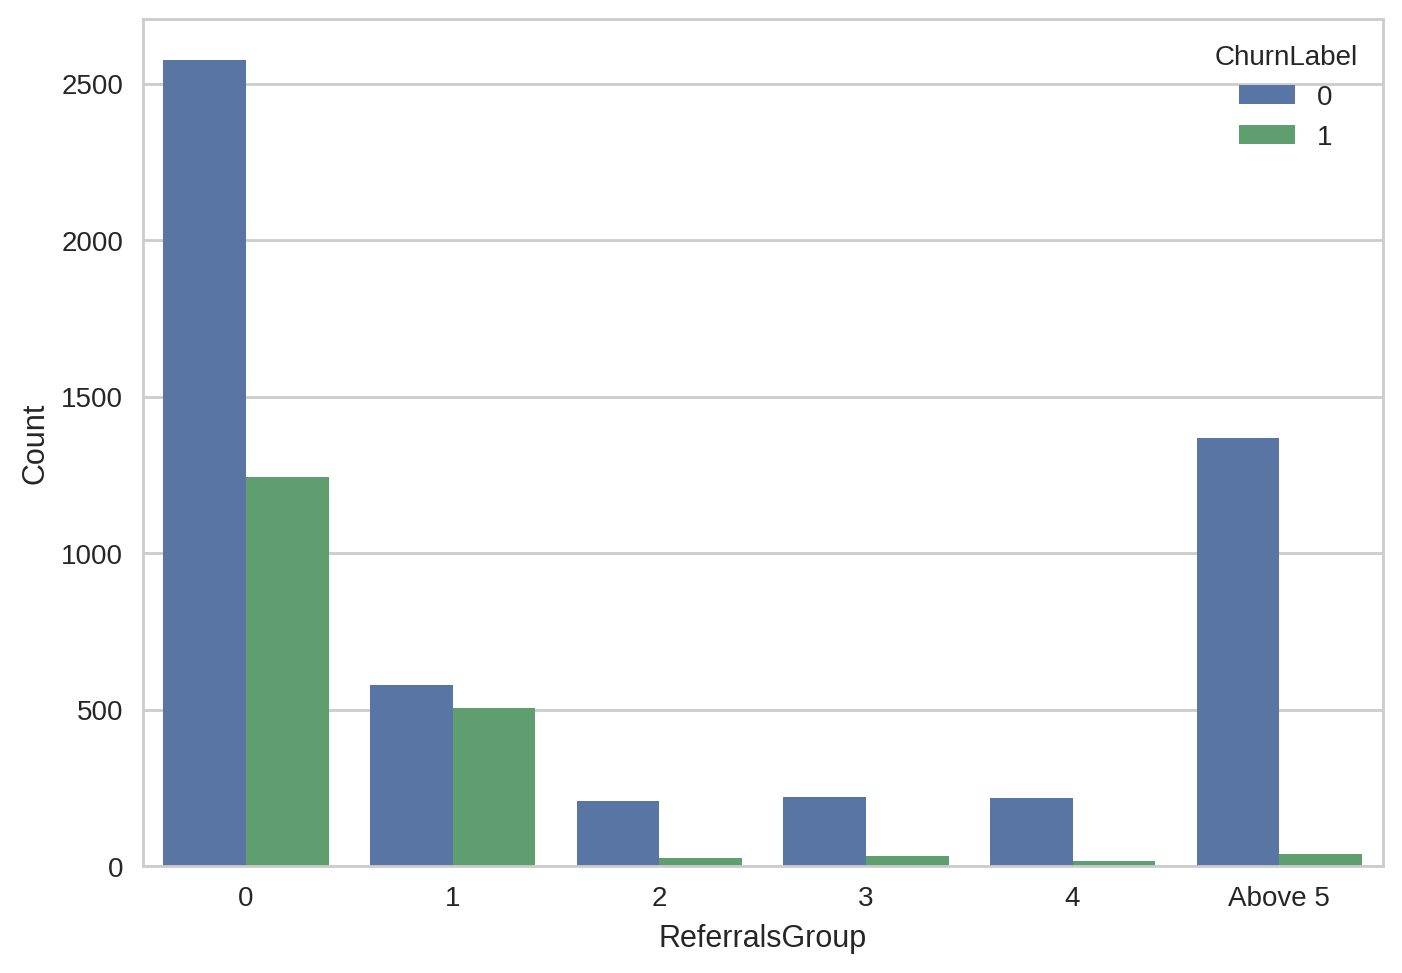

In [ ]:
df = dfTelco.assign(ReferralsGroup = dfTelco.NumberOfReferrals.map(lambda x: x if x < 5 else 'Above 5'))
df = df.groupby(['ReferralsGroup', 'ChurnLabel']).size().rename('Count').reset_index()

sns.barplot(df, x='ReferralsGroup', y='Count', hue='ChurnLabel')
plt.show()

<Axes: xlabel='InternetType', ylabel='Count'>

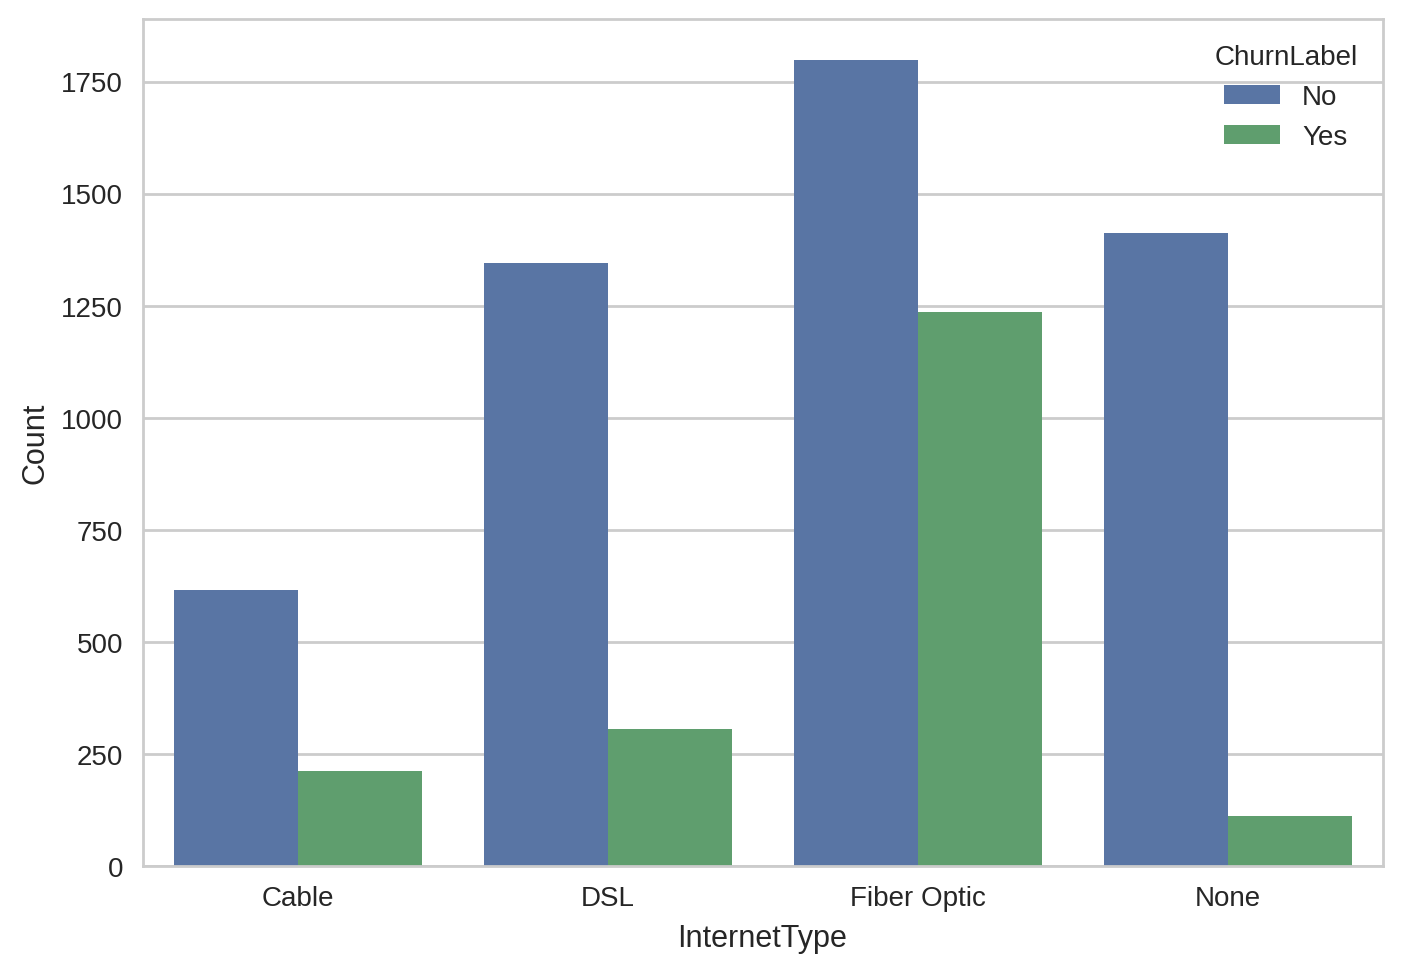

In [ ]:
df = dfTelco.groupby(['InternetType', 'ChurnLabel']).size().rename('Count').reset_index()
sns.barplot(df, x='InternetType', y='Count', hue='ChurnLabel')

<Axes: xlabel='PaymentMethod', ylabel='Count'>

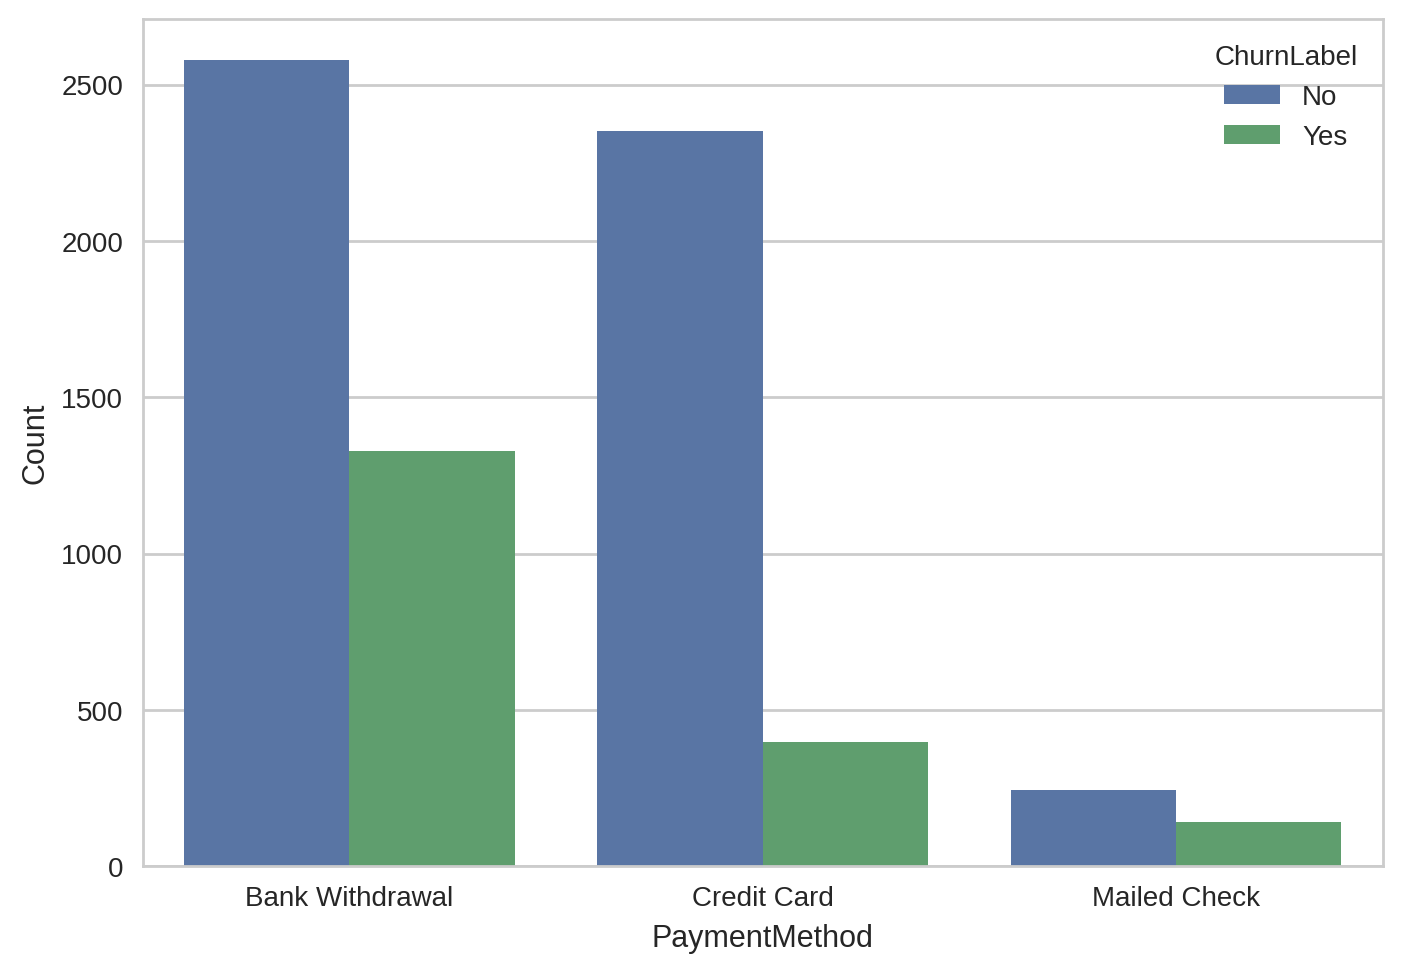

In [ ]:
df = dfTelco.groupby(['PaymentMethod', 'ChurnLabel']).size().rename('Count').reset_index()
sns.barplot(df, x='PaymentMethod', y='Count', hue='ChurnLabel')

<Axes: xlabel='SatisfactionScore', ylabel='Count'>

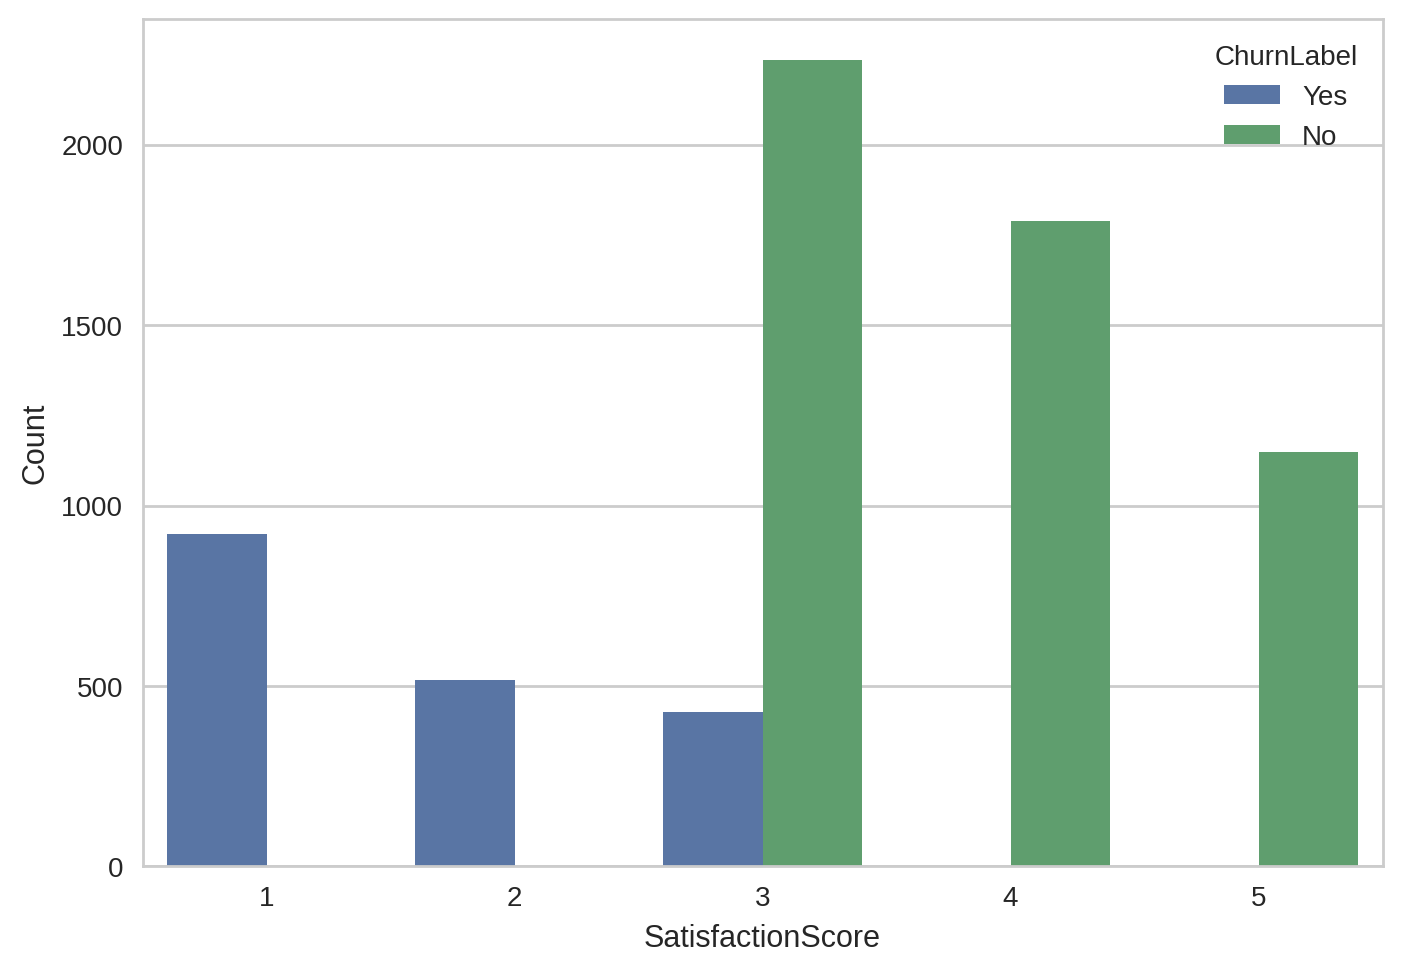

In [ ]:
df = dfTelco.groupby(['SatisfactionScore', 'ChurnLabel']).size().rename('Count').reset_index()
sns.barplot(df, x='SatisfactionScore', y='Count', hue='ChurnLabel')

## 5.2. Churn reason
Most churned customers are attracted by competitor. Since there are so many churn categories, we use a technique called Decision Tree to classify if a customer churn by a specific reason. Findings:
- Not only `dissatisfaction` category has low satisfaction score, but also `competitor` does.
- Customers with low satisfaction score and low tenure is very likely to churn by competitor. This category also contributes high monthly revenue.
- Customers churned by `price` has much less refunds than other groups.


In [ ]:
dfTelco[['ChurnCategory']].value_counts(normalize=True).rename('Percentage').to_frame().style.format('{:.1%}')

,Percentage
ChurnCategory,
Competitor,45.0%
Attitude,16.8%
Dissatisfaction,16.2%
Price,11.3%
Other,10.7%


In [ ]:
dfTelco.groupby('ChurnCategory').agg({
    'SatisfactionScore': [np.mean, np.median],
    'AvgMonthlyRefunds': [np.mean],
    'MonthlyCharge': [np.mean, np.median, np.std],
    'AvgMonthlyRevenue': [np.mean, np.median, np.std],
})

SatisfactionScore        AvgMonthlyRefunds MonthlyCharge  \
                             mean median              mean          mean   
ChurnCategory                                                              
Attitude                 2.041401    2.0          0.140888     70.941561   
Competitor               1.546968    1.0          0.142648     76.728597   
Dissatisfaction          1.709571    1.0          0.160817     74.205281   
Other                    2.005000    2.0          0.060298     75.455500   
Price                    1.819905    2.0          0.095161     69.910664   

                                  AvgMonthlyRevenue                         
                median        std              mean      median        std  
ChurnCategory                                                               
Attitude         78.95  27.830919         94.416458   99.720614  33.956290  
Competitor       80.45  22.645658        101.339013  107.337500  31.671894  
Dissatisfaction  79.25  23.719675         97.122538  102.484286  32.071325  
Other            78.80  22.389042         97.866928  101.305000  30.095958  
Price            78.45  29.345435         94.342307  101.711923  35.339645